# JPX Growth Board Analysis

## Background

This Analysis focuses on the growth board of JPX and will look at the valuation difference, price and fundamental performance of companies listed on the growth board vs the rest of the market and try to give suggestions on actions post IPO for an electronic appliance/service company.

In [188]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import seaborn as sns
from typing import Union, Optional
import typing
import scipy.stats as stats
import sqlite3
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [249]:
dbs = {'jpx_growth': {}, 'japan_indices': {}, 'jasdaq': {}}
for dbname, d in dbs.items():
    print(dbname)
    conn = sqlite3.connect(f'./jpx_analysis/sqldata/{dbname}.db')
    d['desc'] = pd.read_sql(sql='select * from desc', con=conn, index_col=['index'])
    d['market_data'] = pd.read_sql(sql='select * from market_data', con=conn, index_col=['field', 'ticker'])
    d['fundamental_data'] = pd.read_sql(sql='select * from fundamental_data', con=conn, index_col=['level_0', 'level_1'])

jpx_growth
japan_indices
jasdaq


## 1. Compare growth board valuation vs the overall market
As there are many unprofitable companies on the growth board, given the early stage nature, we look at also the price/sales, ev/ebitda, and price/book

As figure 1 shows, growth board stocks in general as a order of magnitude more expensive compared with the rest of the market, and is also much more expensive than the growth-oriented JASDAQ section. This is in part due to the early stage nature of the companies on the board, which tend to have faster growth and depressed margins due to investment in growth. 

- Valuation trend tend to be similar, but growth board tend to be a bit mroe volatile and has seen more pull back recently. 

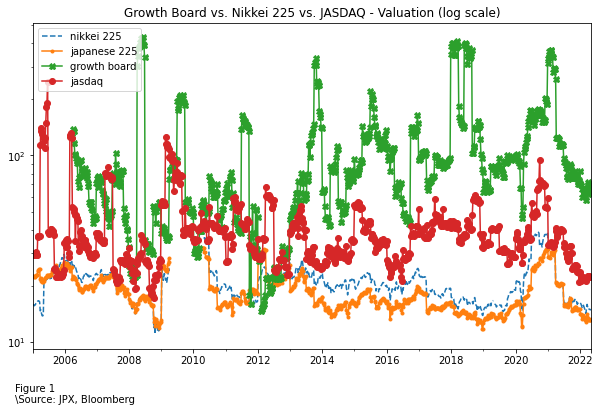

In [251]:
# PE ratio comparison
f, ax = plt.subplots(1, figsize=(10, 6))
chartdata1 = dbs.get('japan_indices').get('market_data').copy(deep=True)
chartdata2 = dbs.get('jpx_growth').get('market_data').copy(deep=True)
chartdata3 = dbs.get('jasdaq').get('market_data').copy(deep=True)
chartdata1.columns = chartdata1.columns.to_series().apply(lambda x: dt.datetime.strptime(x, "%Y-%m-%d"))
chartdata2.columns = chartdata2.columns.to_series().apply(lambda x: dt.datetime.strptime(x, "%Y-%m-%d"))
chartdata3.columns = chartdata3.columns.to_series().apply(lambda x: dt.datetime.strptime(x, "%Y-%m-%d"))
chartdata1.loc[('pe_ratio', 'nky index'), dt.date(2005, 1, 1):].plot(ax=ax, style='--', label='nikkei 225')
chartdata1.loc[('pe_ratio', 'tpx index'), dt.date(2005, 1, 1):].plot(ax=ax, style='.-', label='japanese 225')
chartdata2.loc['pe_ratio', dt.date(2005, 1, 1):].mean(axis=0).plot(ax=ax, style='X-', label='growth board')
chartdata3.loc['pe_ratio', dt.date(2005, 1, 1):].mean(axis=0).plot(ax=ax, style='o-', label='jasdaq')

ax.set(yscale='log', title='Growth Board vs. Nikkei 225 vs. JASDAQ - Valuation (log scale)')
f.text(0.1,0, "Figure 1\n\Source: JPX, Bloomberg")
ax.legend(loc='upper left')

Looking at both P/S and P/B, the growth board overall is about 10x more expensive than the rest of the market.

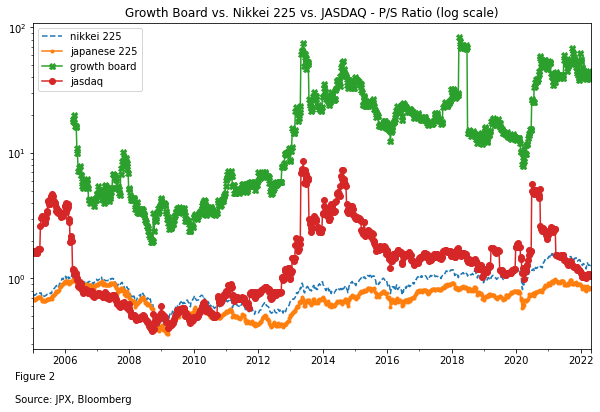

In [252]:
# PS ratio comparison
f, ax = plt.subplots(1, figsize=(10, 6))

chartdata1.loc[('px_to_sales_ratio', 'nky index'), dt.date(2005, 1, 1):].plot(ax=ax, style='--', label='nikkei 225')
chartdata1.loc[('px_to_sales_ratio', 'tpx index'), dt.date(2005, 1, 1):].plot(ax=ax, style='.-', label='japanese 225')
chartdata2.loc['px_to_sales_ratio', dt.date(2005, 1, 1):].mean(axis=0).plot(ax=ax, style='X-', label='growth board')
chartdata3.loc['px_to_sales_ratio', dt.date(2005, 1, 1):].mean(axis=0).plot(ax=ax, style='o-', label='jasdaq')

ax.set(yscale='log', title='Growth Board vs. Nikkei 225 vs. JASDAQ - P/S Ratio (log scale)')
f.text(0.1,0, "Figure 2\n\nSource: JPX, Bloomberg")
ax.legend(loc='upper left')
ax.legend()

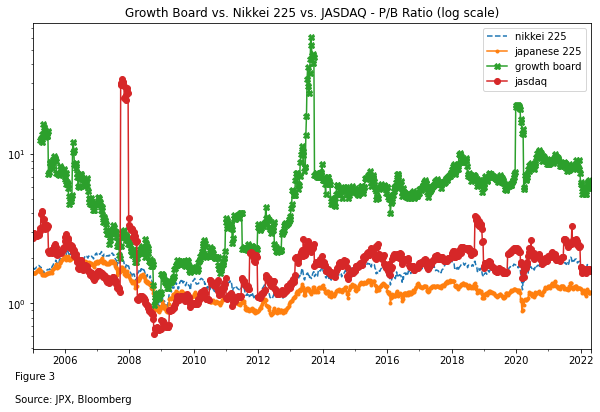

In [253]:
# PB ratio comparison
f, ax = plt.subplots(1, figsize=(10, 6))

chartdata1.loc[('px_to_book_ratio', 'nky index'), dt.date(2005, 1, 1):].plot(ax=ax, style='--', label='nikkei 225')
chartdata1.loc[('px_to_book_ratio', 'tpx index'), dt.date(2005, 1, 1):].plot(ax=ax, style='.-', label='japanese 225')
chartdata2.loc['px_to_book_ratio', dt.date(2005, 1, 1):].mean(axis=0).plot(ax=ax, style='X-', label='growth board')
chartdata3.loc['px_to_book_ratio', dt.date(2005, 1, 1):].mean(axis=0).plot(ax=ax, style='o-', label='jasdaq')

ax.set(yscale='log', title='Growth Board vs. Nikkei 225 vs. JASDAQ - P/B Ratio (log scale)')
f.text(0.1,0, "Figure 3\n\nSource: JPX, Bloomberg")
ax.legend(loc='upper left')
ax.legend()

## 2. Performance since IPO

We can now look at the performance since IPO. We will look at this through the following angles:
1) General performance since IPO;
2) Performance by sector;
3) General market condiction, interest rates, and company characteristics and their impact to IPO performance;

In [193]:
class IPOAnalysis:
    # get start date
    def __init__(self, dbname, datetime_format='%Y-%m-%d'):
        self.dbname = dbname
        self.desc = dbs.get(dbname).get('desc')
        self.desc.eqy_init_po_dt = self.desc.eqy_init_po_dt.apply(lambda x: 
            dt.datetime.strptime(x, datetime_format) if isinstance(x, str) else x)
        self.fundamental_data = dbs.get(dbname).get('fundamental_data')
        if not self.fundamental_data.columns.dtype in ['int32', 'int64']:
            try:
                self.fundamental_data.columns = self.fundamental_data.columns.astype(int)
            except ValueError:
                self.fundamental_data.column = self.fundamental_data.columns.to_series().apply(lambda x: int(x) if x.isdigit() else np.nan)
        self.market_data = dbs.get(dbname).get('market_data')
        if not self.market_data.columns.dtype in ['datetime64[ns]', '<M8[ns]']:
            try:
                self.market_data.columns = self.market_data.columns.astype('datetime64[ns]')
            except ValueError:
                self.market_data.columns = self.market_data.columns.to_series().apply(lambda x: dt.datetime.strptime(x, datetime_format))

    def standardize_by_start(self, field: str='pe_ratio', listing_year: Union[list, None]=None):
        """pull every ticker back to the IPO date"""
        desc = self.desc.copy(deep=True).reset_index()
        data = self.market_data.copy(deep=True).T
        if listing_year:
            desc = desc.loc[desc.eqy_init_po_dt.apply(lambda d: d.year).isin(listing_year).values, :]
        if len(desc):
            start_dates = dict(desc.loc[:, ['index', 'eqy_init_po_dt']].values)
            ls = []
            for ticker, s in data.loc[:, field].iteritems():
                if isinstance(start_dates.get(ticker), dt.date):
                    temp = s.loc[start_dates.get(ticker):].dropna()
                    temp.index = range(len(temp))
                    temp.name = ticker
                    ls.append(temp.to_frame())
            return start_dates, pd.concat([i.T for i in ls]).T
    def get_change_since_ipo(self, field='pe_ratio', sector='Electronic Equipment, Instrume', listing_year=None):
        """get the change since IPO
        :param field: bbg field to be passed to standardize_by_start(), 
        :param sector: if pass 'all', will not be filtered"""
        desc = self.desc.copy(deep=True).reset_index()
        desc.reset_index(inplace=True)
        if sector == 'all': tickers = desc.loc[:, 'index']
        else: tickers = desc.loc[desc.gics_industry_name == sector, 'index'].values
        data = self.standardize_by_start(field=field, listing_year=listing_year)[1]
        tickers = data.columns.intersection(tickers)
        data = data.loc[:, tickers]
        if field != 'px_last': return data - data.iloc[0, :]
        else: 
            ipo_px = dict(desc.loc[:, ['index', 'eqy_init_po_sh_px']].values)
            return data / data.columns.to_series().map(ipo_px).values
    def plot_change_since_ipo(self, field='pe_ratio', sector='Electronic Equipment, Instrume',
        figsize: tuple=(10, 6), xlim=(1, 365), ylim=(-50, 50), listing_year=None):
        data = self.get_change_since_ipo(field=field, sector=sector, listing_year=listing_year)
        n = data.shape[1]
        f, ax = plt.subplots(1, figsize=figsize)
        mean = data.mean(axis=1)
        std = data.std(axis=1)
        ax.plot(mean, label='mean')
        ax.fill_between(x=data.index, y1=mean, y2=mean + std, label = '+1sd', color='lightgray', alpha=0.3)
        ax.fill_between(x=data.index, y1=mean, y2=mean - std, label = '-1sd', color='lightgray', alpha=0.3)
        ax.fill_between(x=data.index, y1=mean, y2=mean + 0.5*std, label = '+0.5sd', color='lightgray', alpha=0.6)
        ax.fill_between(x=data.index, y1=mean, y2=mean - 0.5*std, label = '-0.5sd', color='lightgray', alpha=0.6)
        ax.legend()
        ax.set(title=f"{field} since IPO - listed in {listing_year}\n{sector} sector(s); n={n}", xlim=xlim, ylim=ylim)
        return f

In [247]:
# JPX growth board analysis
ia = IPOAnalysis('jpx_growth')
start_dates, standardized = ia.standardize_by_start()

Looking at the share price performance on the growth board, we can observe a few interesting trends, some of which are generally true with IPOs:

1) After 2013, the average IPOs rise more than 25% from the issue price.
2) It seems like the secondary market is fairly efficient at pricing IPOs, with share prices stablizing after IPOs. The average share price performance 1/4/12 weeks after IPO don't differ that much from the IPO price. 
3) Except for 2019 which was an unusual year (trade war, macro shocks), share price after a year almost always to IPO levels on average. 
4) There are a few bad years such as 2015 when IPOs performed poorly and generally did not rise above the issue prices. Given the macro uncertainties 2022 is likely going to such a year. 

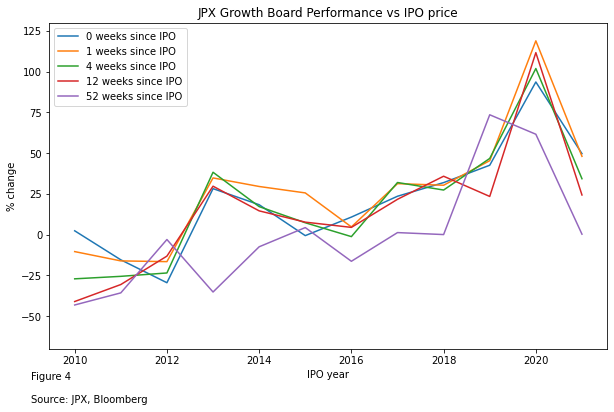

In [255]:
ipo_px_chg = ia.get_change_since_ipo(field='px_last', sector='all', listing_year=list(range(2001, 2022)))
ipo_px_chg.columns = ipo_px_chg.columns.map(start_dates)
ipo_px_chg = ipo_px_chg.T.sort_index()
ipo_px_chg.loc[:, "year"] = ipo_px_chg.index.to_series().apply(lambda d: d.year)
ipo_px_chg.loc[:, "quarter"] = ipo_px_chg.index.to_series().apply(lambda d: d.month // 3)
ipo_px_chg.loc[:, "month"] = ipo_px_chg.index.to_series().apply(lambda d: d.month)
ipo_px_chg.loc[:, "week"] = ipo_px_chg.index.to_series().apply(lambda d: d.day // 7)

f, ax = plt.subplots(1, figsize=(10, 8))
plotdata = ipo_px_chg.groupby(['year']).mean().query("year>=2010")*100 - 100
for day_since_ipo in (0, 1, 4, 12, 52):
    plotdata.iloc[:, day_since_ipo].plot(kind='line',
        figsize=(10, 6), ax=ax, ylim=(-70, 130), label=f"{day_since_ipo} weeks since IPO")
ax.set(yscale='linear', ylabel='% change', xlabel='IPO year', title='JPX Growth Board Performance vs IPO price')
f.text(0.1,0, "Figure 4\n\nSource: JPX, Bloomberg")
ax.legend(loc='upper left')
ax.legend()